In [93]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
from collections import Counter

In [33]:
train = pd.read_csv("./data/train.csv")
train

,ID,사고일시,요일,기상상태,시군구,도로형태,노면상태,사고유형,사고유형 - 세부분류,법규위반,...,가해운전자 상해정도,피해운전자 차종,피해운전자 성별,피해운전자 연령,피해운전자 상해정도,사망자수,중상자수,경상자수,부상자수,ECLO
0,ACCIDENT_00000,2019-01-01 00,화요일,맑음,대구광역시 중구 대신동,단일로 - 기타,건조,차대사람,길가장자리구역통행중,안전운전불이행,...,상해없음,보행자,여,70세,중상,0,1,0,0,5
1,ACCIDENT_00001,2019-01-01 00,화요일,흐림,대구광역시 달서구 감삼동,단일로 - 기타,건조,차대사람,보도통행중,기타,...,상해없음,보행자,남,61세,경상,0,0,1,0,3
2,ACCIDENT_00002,2019-01-01 01,화요일,맑음,대구광역시 수성구 두산동,단일로 - 기타,건조,차대사람,차도통행중,안전운전불이행,...,상해없음,보행자,남,38세,경상,0,0,1,0,3
3,ACCIDENT_00003,2019-01-01 02,화요일,맑음,대구광역시 북구 복현동,단일로 - 기타,건조,차대차,추돌,안전운전불이행,...,상해없음,승용,남,36세,중상,0,1,0,0,5
4,ACCIDENT_00004,2019-01-01 04,화요일,맑음,대구광역시 동구 신암동,단일로 - 기타,건조,차대차,추돌,안전운전불이행,...,상해없음,승용,남,52세,경상,0,0,1,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39604,ACCIDENT_39604,2021-12-31 19,금요일,맑음,대구광역시 수성구 수성동3가,교차로 - 교차로안,건조,차대차,측면충돌,신호위반,...,상해없음,이륜,남,28세,경상,0,0,1,0,3
39605,ACCIDENT_39605,2021-12-31 19,금요일,맑음,대구광역시 달서구 상인동,단일로 - 기타,건조,차대차,측면충돌,안전거리미확보,...,상해없음,승용,남,52세,경상,0,0,1,0,3
39606,ACCIDENT_39606,2021-12-31 21,금요일,맑음,대구광역시 달서구 월성동,교차로 - 교차로안,건조,차대차,측면충돌,교차로운행방법위반,...,중상,승용,남,73세,중상,0,2,0,0,10
39607,ACCIDENT_39607,2021-12-31 22,금요일,맑음,대구광역시 달서구 장동,기타 - 기타,건조,차대차,추돌,안전운전불이행,...,상해없음,승용,여,57세,경상,0,0,1,0,3


In [34]:
# 피하자의 정보에 Na 값이 있는 것을 확인
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39609 entries, 0 to 39608
Data columns (total 23 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ID           39609 non-null  object
 1   사고일시         39609 non-null  object
 2   요일           39609 non-null  object
 3   기상상태         39609 non-null  object
 4   시군구          39609 non-null  object
 5   도로형태         39609 non-null  object
 6   노면상태         39609 non-null  object
 7   사고유형         39609 non-null  object
 8   사고유형 - 세부분류  39609 non-null  object
 9   법규위반         39609 non-null  object
 10  가해운전자 차종     39609 non-null  object
 11  가해운전자 성별     39609 non-null  object
 12  가해운전자 연령     39609 non-null  object
 13  가해운전자 상해정도   39609 non-null  object
 14  피해운전자 차종     38618 non-null  object
 15  피해운전자 성별     38618 non-null  object
 16  피해운전자 연령     38618 non-null  object
 17  피해운전자 상해정도   38618 non-null  object
 18  사망자수         39609 non-null  int64 
 19  중상자수         39609 non-nu

In [106]:
Counter(train.사고유형)

Counter({'차대차': 31785, '차대사람': 6833, '차량단독': 991})

In [105]:
# 차량단독은 전부 피해자가 없음
NA = train[train["피해운전자 차종"].isna( )]
for column in ['요일', '기상상태', '도로형태', '노면상태', '사고유형',
       '사고유형 - 세부분류', '법규위반', '가해운전자 차종', '가해운전자 성별', '가해운전자 연령', '가해운전자 상해정도']:
    print("{} \n{}\n".format(column, Counter(NA[column])))

요일 
Counter({'토요일': 164, '금요일': 153, '월요일': 141, '화요일': 138, '수요일': 137, '일요일': 130, '목요일': 128})

기상상태 
Counter({'맑음': 853, '비': 115, '흐림': 20, '눈': 2, '기타': 1})

도로형태 
Counter({'단일로 - 기타': 671, '교차로 - 교차로부근': 109, '교차로 - 교차로안': 96, '기타 - 기타': 65, '단일로 - 지하차도(도로)내': 14, '주차장 - 주차장': 10, '단일로 - 교량': 9, '단일로 - 고가도로위': 7, '교차로 - 교차로횡단보도내': 5, '단일로 - 터널': 4, '미분류 - 미분류': 1})

노면상태 
Counter({'건조': 840, '젖음/습기': 136, '기타': 8, '서리/결빙': 6, '침수': 1})

사고유형 
Counter({'차량단독': 991})

사고유형 - 세부분류 
Counter({'기타': 501, '공작물충돌': 324, '전도전복 - 전도': 144, '전도전복 - 전복': 10, '도로외이탈 - 추락': 8, '도로외이탈 - 기타': 4})

법규위반 
Counter({'안전운전불이행': 853, '기타': 112, '안전거리미확보': 9, '과속': 8, '교차로운행방법위반': 3, '불법유턴': 3, '중앙선침범': 1, '직진우회전진행방해': 1, '신호위반': 1})

가해운전자 차종 
Counter({'승용': 382, '이륜': 236, '승합': 210, '자전거': 62, '화물': 37, '원동기': 33, '개인형이동수단(PM)': 16, '기타불명': 10, '건설기계': 3, '특수': 1, '사륜오토바이(ATV)': 1})

가해운전자 성별 
Counter({'남': 863, '여': 121, '기타불명': 7})

가해운전자 연령 
Counter({'56세': 35, '62세': 32, '52세': 26, '57세': 26, '

# EDA

### 1. 데이터 구성 변경

In [57]:
train_new = train.copy()

# ID 삭제
train_new = train_new.drop(["ID"], axis = 1)

# Hour 변수 추가
train_new["Hour"] = [i.split()[1] for i in train_new.사고일시]
train_new["사고일시"] = [i.split()[0] for i in train_new.사고일시]

# Year, Month, Day 변수 추가
train_new["Year"] = [i.split("-")[0] for i in train_new.사고일시]
train_new["Month"] = [i.split("-")[1] for i in train_new.사고일시]
train_new["Day"] = [i.split("-")[2] for i in train_new.사고일시]
train_new = train_new.drop(["사고일시"], axis = 1)

# 총 인원 변수 추가
train_new["Total"] = [train_new[["사망자수","중상자수","경상자수","부상자수"]].iloc[i].sum() for i in range(len(train_new))]

# 나이대별 범주화


# 시군구 분리

# 세부분류 분리

# 도로형태 분리


In [58]:
# 범주형 변수 전부 라벨링
for column in ['요일', '기상상태', '시군구', '도로형태', '노면상태', '사고유형', '사고유형 - 세부분류', '법규위반',
       '가해운전자 차종', '가해운전자 성별', '가해운전자 연령', '가해운전자 상해정도', '피해운전자 차종',
       '피해운전자 성별', '피해운전자 연령', '피해운전자 상해정도', 'Hour', 'Year', 'Month', 'Day']:
    le = LabelEncoder()
    le.fit(train_new[column])
    train_new[column] = le.transform(train_new[column])


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39609 entries, 0 to 39608
Data columns (total 26 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   요일           39609 non-null  int32
 1   기상상태         39609 non-null  int32
 2   시군구          39609 non-null  int32
 3   도로형태         39609 non-null  int32
 4   노면상태         39609 non-null  int32
 5   사고유형         39609 non-null  int32
 6   사고유형 - 세부분류  39609 non-null  int32
 7   법규위반         39609 non-null  int32
 8   가해운전자 차종     39609 non-null  int32
 9   가해운전자 성별     39609 non-null  int32
 10  가해운전자 연령     39609 non-null  int32
 11  가해운전자 상해정도   39609 non-null  int32
 12  피해운전자 차종     39609 non-null  int32
 13  피해운전자 성별     39609 non-null  int32
 14  피해운전자 연령     39609 non-null  int32
 15  피해운전자 상해정도   39609 non-null  int32
 16  사망자수         39609 non-null  int64
 17  중상자수         39609 non-null  int64
 18  경상자수         39609 non-null  int64
 19  부상자수         39609 non-null  int64
 20  ECLO  

In [71]:
train_new.corr()

,요일,기상상태,시군구,도로형태,노면상태,사고유형,사고유형 - 세부분류,법규위반,가해운전자 차종,가해운전자 성별,...,사망자수,중상자수,경상자수,부상자수,ECLO,Hour,Year,Month,Day,Total
요일,1.000000,0.003608,0.004577,-0.001011,0.012741,0.012525,-0.001501,0.006844,-0.013971,-0.009515,...,0.004996,0.008612,0.020338,0.007270,0.027895,-0.026245,-0.013370,-0.002333,-0.000638,0.029451
기상상태,0.003608,1.000000,-0.017900,-0.011271,0.625393,0.000596,0.006221,-0.010530,0.003692,-0.025458,...,0.006727,0.015987,-0.005108,-0.004393,0.009092,0.015927,0.033193,-0.014193,-0.002997,0.001919
시군구,0.004577,-0.017900,1.000000,0.025542,-0.000768,-0.007216,0.044912,0.017783,-0.015836,0.000459,...,-0.002488,0.008179,-0.015167,0.053605,-0.001790,-0.025016,-0.002048,-0.006745,0.004716,0.010572
도로형태,-0.001011,-0.011271,0.025542,1.000000,-0.012289,-0.075271,-0.081859,0.212754,-0.018257,-0.026005,...,0.015184,-0.028492,-0.019919,-0.001233,-0.036617,0.002900,-0.002827,0.002201,0.002564,-0.035107
노면상태,0.012741,0.625393,-0.000768,-0.012289,1.000000,0.011265,-0.010013,-0.004514,-0.002209,-0.024839,...,0.014980,0.018359,-0.002797,-0.001122,0.015810,0.023081,0.026779,-0.021993,-0.015968,0.007760
사고유형,0.012525,0.000596,-0.007216,-0.075271,0.011265,1.000000,0.083999,0.083042,0.033774,0.020205,...,-0.022436,-0.076140,0.175577,0.049153,0.103219,-0.027992,0.008726,0.002244,-0.002935,0.162483
사고유형 - 세부분류,-0.001501,0.006221,0.044912,-0.081859,-0.010013,0.083999,1.000000,-0.023955,0.005423,0.056608,...,-0.015917,0.001383,0.113625,-0.032889,0.097998,0.004155,0.008784,-0.001997,0.003300,0.104845
법규위반,0.006844,-0.010530,0.017783,0.212754,-0.004514,0.083042,-0.023955,1.000000,-0.008516,-0.006970,...,-0.010372,-0.056361,0.024587,0.020066,-0.021637,-0.012467,-0.004991,0.001453,-0.000280,0.003334
가해운전자 차종,-0.013971,0.003692,-0.015836,-0.018257,-0.002209,0.033774,0.005423,-0.008516,1.000000,-0.093532,...,0.031123,0.035729,-0.048653,0.013295,-0.006869,-0.021684,0.009963,-0.001770,-0.008783,-0.023638
가해운전자 성별,-0.009515,-0.025458,0.000459,-0.026005,-0.024839,0.020205,0.056608,-0.006970,-0.093532,1.000000,...,-0.013010,0.000172,0.057862,-0.056676,0.043198,0.015046,0.005125,0.002723,0.005021,0.035952


<Axes: >

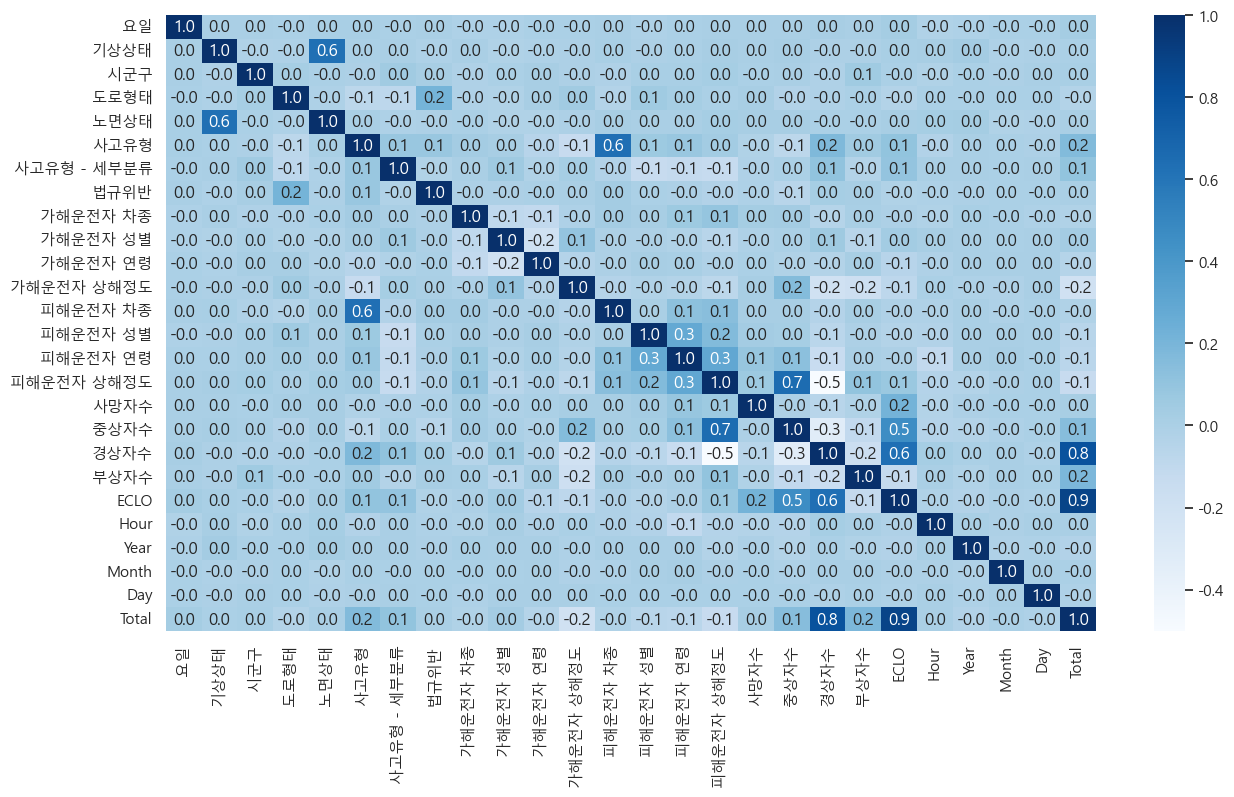

In [82]:
sns.set(rc={"figure.figsize": (15, 8)})
sns.set(font="Malgun Gothic", 
        rc={"axes.unicode_minus":False},
        style='darkgrid')
sns.heatmap(train_new.corr(), annot = True, fmt = ".1f", cmap="Blues")

In [62]:
train_new

,요일,기상상태,시군구,도로형태,노면상태,사고유형,사고유형 - 세부분류,법규위반,가해운전자 차종,가해운전자 성별,...,사망자수,중상자수,경상자수,부상자수,ECLO,Hour,Year,Month,Day,Total
0,6,2,155,6,0,0,2,7,5,2,...,0,1,0,0,5,0,0,0,0,1
1,6,5,4,6,0,0,5,2,5,1,...,0,0,1,0,3,0,0,0,0,1
2,6,2,124,6,0,0,9,7,5,1,...,0,0,1,0,3,1,0,0,0,1
3,6,2,98,6,0,1,10,7,5,1,...,0,1,0,0,5,2,0,0,0,1
4,6,2,65,6,0,1,10,7,5,1,...,0,0,1,0,3,4,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39604,0,2,135,1,0,1,11,5,5,2,...,0,0,1,0,3,19,2,11,30,1
39605,0,2,11,6,0,1,11,6,5,2,...,0,0,1,0,3,19,2,11,30,1
39606,0,2,16,1,0,1,11,1,5,1,...,0,2,0,0,10,21,2,11,30,2
39607,0,2,21,3,0,1,10,7,5,1,...,0,0,1,0,3,22,2,11,30,1


<Axes: xlabel='Year'>

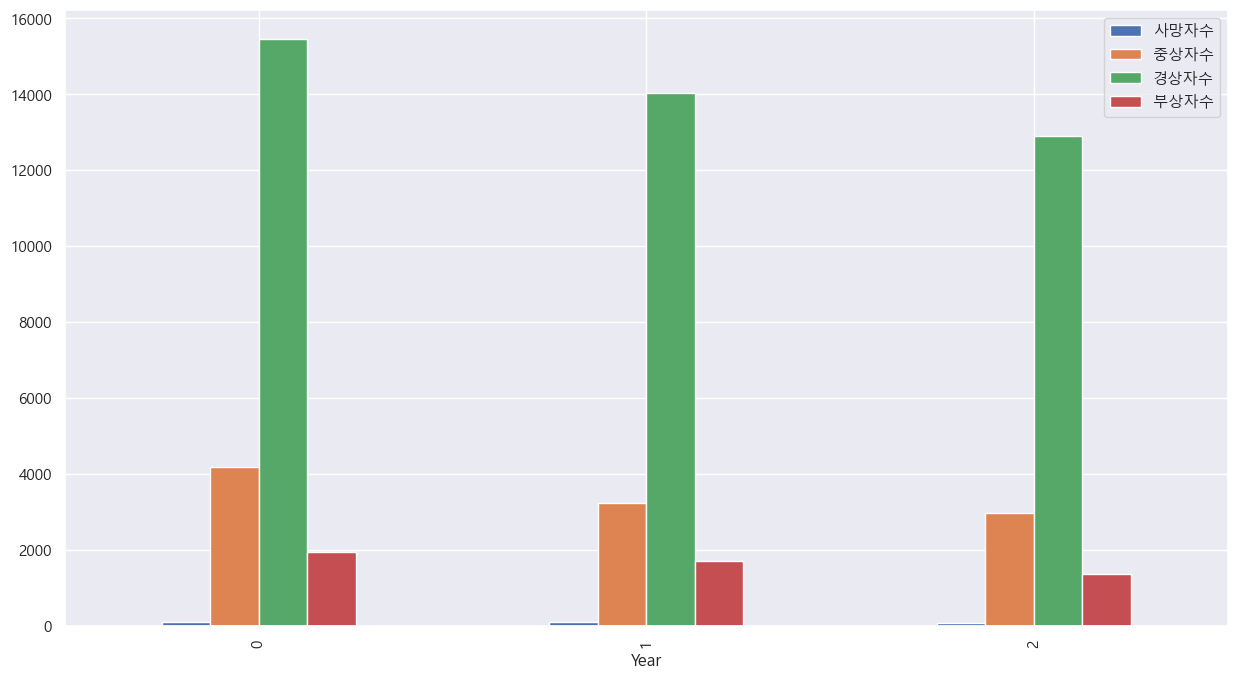

In [68]:
# 한글 깨짐
plt.rcParams['font.family'] = 'Malgun Gothic'

# Year 기준 전체적으로 줄어가는 추세
# Month, Day, 요일은 큰 의미없음
train_new.groupby("Year").sum()[["사망자수","중상자수","경상자수","부상자수"]].plot(kind = "bar")

<Axes: xlabel='기상상태'>

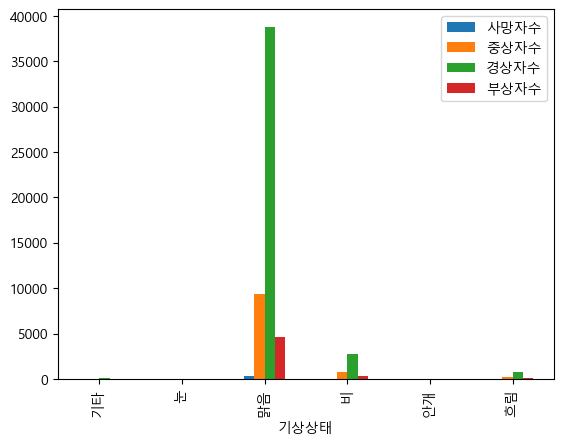

In [37]:
# 맑은 날이 많아서인지 맑은 날 가장 사고가 많음
train_new.groupby("기상상태").sum()[["사망자수","중상자수","경상자수","부상자수"]].plot(kind = "bar")

In [38]:
# 단일로 - 기타, 교차로-교차로안이 유독 많음
train_new.groupby(["도로형태"]).sum()[["사망자수","중상자수","경상자수","부상자수", "ECLO"]]

,사망자수,중상자수,경상자수,부상자수,ECLO
도로형태,,,,,
교차로 - 교차로부근,28,1376,6670,773,27943
교차로 - 교차로안,66,2933,11036,1283,49716
교차로 - 교차로횡단보도내,18,585,945,137,6077
기타 - 기타,9,444,1850,215,8075
단일로 - 고가도로위,2,24,207,14,775
단일로 - 교량,3,48,305,24,1209
단일로 - 기타,178,4849,20719,2501,90683
단일로 - 지하차도(도로)내,1,81,320,39,1414
단일로 - 터널,3,16,102,5,421


In [39]:
# 건조할 경우 전체 사고가 많음
train_new.groupby(["노면상태"]).sum()[["사망자수","중상자수","경상자수","부상자수", "ECLO"]]

,사망자수,중상자수,경상자수,부상자수,ECLO
노면상태,,,,,
건조,268,9454,39023,4624,171643
기타,2,20,37,6,237
서리/결빙,0,6,22,8,104
적설,0,0,3,0,9
젖음/습기,37,912,3298,386,15210
침수,1,0,2,1,17


In [20]:

train.groupby(["사고유형 - 세부분류"]).sum()[["사망자수","중상자수","경상자수","부상자수", "ECLO"]]

,사망자수,중상자수,경상자수,부상자수,ECLO
사고유형 - 세부분류,,,,,
공작물충돌,27,121,175,94,1494
기타,79,2724,9672,1503,44929
길가장자리구역통행중,0,100,300,72,1472
도로외이탈 - 기타,0,0,2,2,8
도로외이탈 - 추락,3,3,3,0,54
보도통행중,5,192,311,41,1984
전도전복 - 전도,5,45,56,57,500
전도전복 - 전복,1,7,4,2,59
정면충돌,17,329,908,98,4637


In [21]:
# 안전운전불이행이 사고를 가장 많이 일으킴
train.groupby(["법규위반"]).sum()[["사망자수","중상자수","경상자수","부상자수", "ECLO"]]

,사망자수,중상자수,경상자수,부상자수,ECLO
법규위반,,,,,
과속,22,88,140,15,1095
교차로운행방법위반,1,685,3339,352,13804
기타,19,439,1072,166,5767
보행자보호의무위반,8,517,644,48,4645
불법유턴,6,106,412,52,1878
신호위반,37,1582,3963,378,20547
안전거리미확보,7,963,7076,768,26881
안전운전불이행,191,5255,22354,2845,98092
중앙선침범,15,346,965,117,4892


In [22]:

train.groupby(["가해운전자 차종"]).sum()[["사망자수","중상자수","경상자수","부상자수", "ECLO"]]

,사망자수,중상자수,경상자수,부상자수,ECLO
가해운전자 차종,,,,,
개인형이동수단(PM),0,51,92,46,577
건설기계,6,134,498,21,2245
기타불명,0,114,579,367,2674
농기계,0,0,3,1,10
사륜오토바이(ATV),0,3,3,5,29
승용,165,6790,30998,2585,131179
승합,15,463,1366,166,6729
원동기,4,138,333,121,1850
이륜,47,1132,3432,1019,17445


In [23]:

train.groupby(["가해운전자 성별"]).sum()[["사망자수","중상자수","경상자수","부상자수", "ECLO"]]

,사망자수,중상자수,경상자수,부상자수,ECLO
가해운전자 성별,,,,,
기타불명,0,113,589,368,2700
남,263,7912,30955,3615,138670
여,45,2367,10841,1042,45850


<Axes: xlabel='가해운전자 연령'>

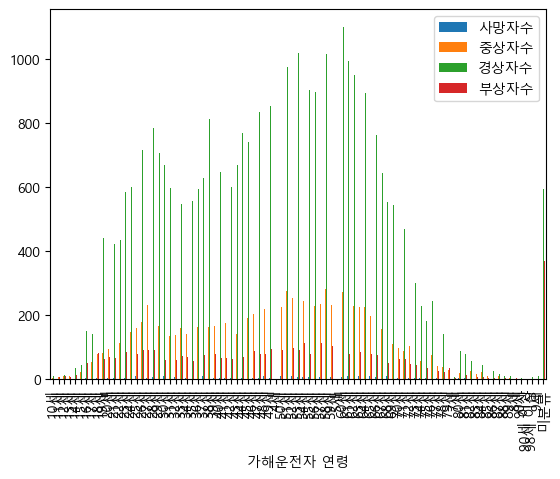

In [28]:
train.groupby(["가해운전자 연령"]).sum()[["사망자수","중상자수","경상자수","부상자수"]].plot(kind = "bar")

In [30]:
train.groupby(["가해운전자 상해정도"]).sum()[["사망자수","중상자수","경상자수","부상자수", "ECLO"]]

,사망자수,중상자수,경상자수,부상자수,ECLO
가해운전자 상해정도,,,,,
경상,10,594,7927,153,27004
기타불명,4,428,2334,483,9665
부상신고,3,255,1363,2661,8055
사망,95,18,36,0,1148
상해없음,176,7724,30113,1711,132430
중상,20,1373,612,17,8918


In [32]:
train.groupby(["가해운전자 차종","피해운전자 차종"]).sum()[["사망자수","중상자수","경상자수","부상자수", "ECLO"]]

사망자수  중상자수  경상자수  부상자수  ECLO
가해운전자 차종    피해운전자 차종                                 
개인형이동수단(PM) 개인형이동수단(PM)     0     3     2     1    22
            기타불명            0     0     0     1     1
            보행자             0    21    33     6   210
            승용              0    17    31    25   203
            승합              0     0     2     1     7
...                       ...   ...   ...   ...   ...
화물          원동기             0    23    38     7   236
            이륜              5   188   288    21  1875
            자전거             3    95   133     9   913
            특수              0     6    12     0    66
            화물             10    93   451    33  1951

[117 rows x 5 columns]

In [29]:
train.columns

Index(['요일', '기상상태', '시군구', '도로형태', '노면상태', '사고유형', '사고유형 - 세부분류', '법규위반',
       '가해운전자 차종', '가해운전자 성별', '가해운전자 연령', '가해운전자 상해정도', '피해운전자 차종',
       '피해운전자 성별', '피해운전자 연령', '피해운전자 상해정도', '사망자수', '중상자수', '경상자수', '부상자수',
       'ECLO', 'Hour', 'Year', 'Month', 'Day'],
      dtype='object')